### Ultramagnet: calculate fields

#### Purpose

To calculate some magneto-seismic properties of the ultramassive white dwarf models and magnetic field evolutions run by Daniel Blatman, in the ultramagnet project.

In [1]:
from qol.seismology.Seismology import Seismology
import qol.mesa.const as const

from astropy.table import Table

import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

First, read Daniel's files:

In [2]:
def read_ultramagnet_run(field_fname, profile_fname, B0_MG=1, name=''):
    """
    Read Daniel Blatman's MESA profiles and magnetic field evolutions

    Bc_MG_init: initial core magnetic field
    """
    # Read data table and make sure they're the same length
    field_table = Table.read(field_fname, format='ascii', header_start=1)
    profile_table = Table.read(profile_fname, format='ascii', header_start=1)

    # Also read age
    with open(field_fname, 'r') as f:
        text = f.read()
    age = float(text.split('time relative to tcryst: ')[1].split(' years\n')[0])

    # Grab quantities from profile
    R = const.Rsun * profile_table['r']
    N = np.sqrt(np.clip(profile_table['N_squared'], a_min=0, a_max=None))
    Sl1 = np.sqrt(2) * profile_table['c_sound'] / R
    Rho = profile_table['rho']

    # The two files will not have the same radii or even be ordered the same, so interpolate the field onto the profile's grid
    B_div_B0 = interp1d(field_table['r/r_wd'], field_table['B/B0'],
                        kind='linear', fill_value=(field_table['B/B0'][0], field_table['B/B0'][-1]), bounds_error=False)

    Br_MG = B0_MG * B_div_B0(profile_table['r/r_wd'])

    # Create Seismology object
    seismology = Seismology(R=R, N=N, Sl1=Sl1, Rho=Rho, Br_MG=Br_MG)

    # Kludge: dynamically add attributes corresponding to other quantities
    seismology.age = age
    seismology.B_affect_conv = profile_table['B_crit'] # sqrt(4 pi rho) * v_conv
    seismology.B_suppress_conv = profile_table['B_crit_p'] # sqrt(8 pi p)
    seismology.field_fname = field_fname
    seismology.profile_fname = profile_fname

    seismology.one_minus_frac_R = 1 - profile_table['r/r_wd']

    return seismology
    

Define initial parameters and where the paths to things are

In [5]:
c_o_rundir = '../data/ultramagnet/c_o/'
o_ne_rundir = '../data/ultramagnet/o_ne/'
l = 1
B0_MG = 1 # starting internal magnetic field
P_min, P_max = 137.7583, 1345.7924 # min and max periods of WD J0135, in s

run_infos = []

run_infos.append({'name': 'CO snapshot 1',
                 'profile': f'{c_o_rundir}table_data_profile_1.txt',
                 'field': f'{c_o_rundir}table_data_1_matlab.txt'})
run_infos.append({'name': 'CO snapshot 2',
                 'profile': f'{c_o_rundir}table_data_profile_2.txt',
                 'field': f'{c_o_rundir}table_data_2_matlab.txt'})
run_infos.append({'name': 'CO snapshot 3',
                 'profile': f'{c_o_rundir}table_data_profile_3.txt',
                 'field': f'{c_o_rundir}table_data_3_matlab.txt'})
run_infos.append({'name': 'CO snapshot 4',
                 'profile': f'{c_o_rundir}table_data_profile_4.txt',
                 'field': f'{c_o_rundir}table_data_4_matlab.txt'})

run_infos.append({'name': 'ONe snapshot 1',
                 'profile': f'{o_ne_rundir}table_data_profile_1.txt',
                 'field': f'{o_ne_rundir}table_data_1_matlab.txt'})
run_infos.append({'name': 'ONe snapshot 2',
                 'profile': f'{o_ne_rundir}table_data_profile_2.txt',
                 'field': f'{o_ne_rundir}table_data_2_matlab.txt'})
run_infos.append({'name': 'ONe snapshot 3',
                 'profile': f'{o_ne_rundir}table_data_profile_3.txt',
                 'field': f'{o_ne_rundir}table_data_3_matlab.txt'})
run_infos.append({'name': 'ONe snapshot 4',
                 'profile': f'{o_ne_rundir}table_data_profile_4.txt',
                 'field': f'{o_ne_rundir}table_data_4_matlab.txt'})


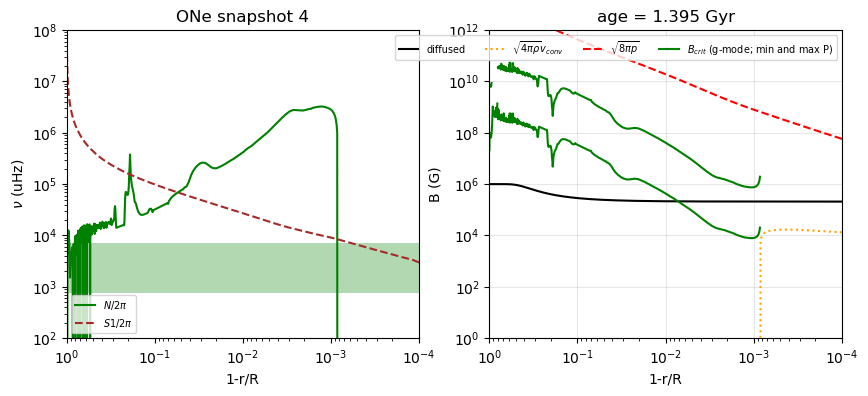

In [12]:
for run_info in run_infos:
    name = run_info['name']
    profile_fname = run_info['profile']
    field_fname = run_info['field']

    seismology = read_ultramagnet_run(field_fname=field_fname, profile_fname=profile_fname, B0_MG=B0_MG)

    plt.close()
    plt.figure(figsize=(10, 4))

    plt.subplot(121)

    plt.plot(seismology.one_minus_frac_R, seismology.N_div_2pi_in_uHz, c='green', ls='-', label='$N/2\pi$')
    plt.plot(seismology.one_minus_frac_R, seismology.Sl_div_2pi_in_uHz(l), c='brown', ls='--', label=f'$S{l}/2\pi$')
    plt.fill_between([1, 1e-4], 2*[1e6/P_min], 2*[1e6/P_max], edgecolor='none', facecolor='green', alpha=0.3)

    plt.xlabel('1-r/R'); plt.xlim(1, 1e-4); plt.xscale('log')
    plt.ylabel(r'$\nu$ (uHz)'); plt.ylim(1e2, 1e7); plt.yscale('log')
    plt.legend(loc='lower left', fontsize=7)
    plt.title(name)

    plt.subplot(122)

    plt.plot(seismology.one_minus_frac_R, seismology.Br, c='k', ls='-', label='diffused')
    plt.plot(seismology.one_minus_frac_R, seismology.B_affect_conv, c='orange', ls='dotted', label=r'$\sqrt{4\pi\rho}v_{conv}$')
    plt.plot(seismology.one_minus_frac_R, seismology.B_suppress_conv, c='red', ls='--', label=r'$\sqrt{8\pi p}$')

    Bcrit_min = seismology.get_Bcrit(l=l, P=P_max, acrit_ref='F+15') # g-mode suppression
    Bcrit_max = seismology.get_Bcrit(l=l, P=P_min, acrit_ref='F+15')
    # plt.fill_between(seismology.one_minus_frac_R, Bcrit_min, Bcrit_max, edgecolor='none', facecolor='green', alpha=0.3, label='$B_{crit}$ (g-mode)')
    plt.plot(seismology.one_minus_frac_R, Bcrit_min, c='green', label='$B_{crit}$ (g-mode; min and max P)')
    plt.plot(seismology.one_minus_frac_R, Bcrit_max, c='green')

    plt.xlabel('1-r/R'); plt.xlim(1, 1e-4); plt.xscale('log')
    plt.ylabel('B (G)'); plt.ylim(1, 1e12); plt.yscale('log')
    plt.legend(loc='upper right', fontsize=7, ncols=4)
    plt.grid(alpha=0.3)
    plt.title(f'age = {seismology.age/1e9:.3f} Gyr')

    plt.savefig(f'plots/ultramagnet_{name.replace(" ", "_")}.png', bbox_inches='tight')
    